In [ ]:
! pip install ultralytics opencv-python-headless supervision wget matplotlib PyYAML tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.1 MB/s eta 0:00:00
  C

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Example path if you saved the shortcut to "My Drive"
data_path = "/content/drive/My Drive/minneApple_dataset"

# Optional: list files
os.listdir(data_path)


['test', 'valid', 'train', '.DS_Store', 'minneapple.yaml']

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path
import os
from ultralytics.data.utils import download
import yaml
import random
from IPython.display import Image, display
import pandas as pd


# def train_yolo_model(dataset_path, epochs, train_name="experiment"):
#    """
#    Train YOLOv10 model on a dataset
#    """

    # TO-DO: Download and train YOLO8 model.
#    model = YOLO("yolov10m.pt")  # Load a pre-trained YOLOv8 model
#    results = model.train(data=str(dataset_path / 'minneapple.yaml'),
#                          epochs=epochs,
#                          imgsz=640,
#                          name=train_name)
#    return model, results

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

def train_yolo_model(dataset_path, epochs=100, train_name="yolov10m_final_improved"):
    model = YOLO("yolov10l.pt")
    results = model.train(
        data=str(dataset_path / 'minneapple.yaml'),
        epochs=epochs,
        imgsz=640,
        batch=4,
        name=train_name,
        optimizer="SGD",
        lr0=0.005,
        lrf=0.1,
        warmup_epochs=3.0,
        warmup_momentum=0.8,
        warmup_bias_lr=0.1,
        fliplr=0.5,
        flipud=0.5,
        mosaic=1.0,
        mixup=0.3,
        copy_paste=0.2,
        scale=0.4,
        translate=0.1,
        perspective=0.0,
        auto_augment="randaugment",
        cache="disk",
        pretrained=True,
        device=0,
        half=True,
        workers=1
    )
    return model, results


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


mAP (mean Average Precision).  
- mAP@0.50 (or mAP50): Evaluates how well predictions match the ground truth at a single IoU threshold of 0.50.
- IoU (Intersection over Union) = area of overlap / area of union.
- A detection is considered correct if IoU ≥ 0.50.
- Lenient — good for understanding if the model can generally find objects.

| Metric         | IoU Threshold      | Strictness | Use Case                     |
| -------------- | ------------------ | ---------- | ---------------------------- |
| mAP\@0.50      | IoU ≥ 0.50         | Low        | Quick check of detection     |
| mAP\@0.50:0.95 | IoU 0.50–0.95 avg. | High       | Real-world precision & rigor |


In [ ]:
def show_confusion_matrix(metrics):
    confusion_path = metrics.save_dir / "confusion_matrix.png"
    if confusion_path.exists():
        display(Image(filename=str(confusion_path)))
    else:
        print("No confusion matrix image found.")

In [ ]:
def evaluate_model(model, dataset_path):
    """
    Evaluate trained model on test-set using mAP50 and mAP50-95, precision and recall.
    """
    test_data = str(dataset_path / 'minneapple.yaml')
    metrics = model.val(data=test_data)

    # Extract from results_dict
    precision = metrics.results_dict['metrics/precision(B)']
    recall = metrics.results_dict['metrics/recall(B)']
    map50 = metrics.results_dict['metrics/mAP50(B)']
    map95 = metrics.results_dict['metrics/mAP50-95(B)']


    print("\n📊 Evaluation Metrics")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"mAP@0.50:       {map50:.4f}")
    print(f"mAP@0.5:0.95:   {map95:.4f}")

    if precision is not None and recall is not None:
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        print(f"F1 Score:       {f1:.4f}")

    if recall < 0.7:
        print("⚠️  Could improve recall — model is missing some objects (false negatives).")
    if precision < 0.7:
        print("⚠️  Could improve precision — model may have false positives.")

    return metrics



In [ ]:
def evaluate_model_on_counting():
    gt_file = "/content/drive/MyDrive/minneApple_dataset/test/ground_truth.txt"
    pred_dir = "/content/drive/MyDrive/yolo10_output/predict_test/labels"

    gt_df = pd.read_csv(gt_file)
    gt_df["image_id"] = gt_df["Image"].str.replace(".png", "", regex=False)

    # Count predicted boxes per image
    pred_counts = {}
    for fname in os.listdir(pred_dir):
        if fname.endswith(".txt"):
            with open(os.path.join(pred_dir, fname), "r") as f:
                count = len(f.readlines())
            pred_counts[fname.replace(".txt", "")] = count

    # Merge and compute metrics
    gt_df["predicted"] = gt_df["image_id"].map(pred_counts).fillna(0).astype(int)

    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(gt_df["count"], gt_df["predicted"])
    mse = mean_squared_error(gt_df["count"], gt_df["predicted"])
    rmse = np.sqrt(mse)
    r2 = r2_score(gt_df["count"], gt_df["predicted"])

    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²   : {r2:.3f}")

In [ ]:


def visualize_predictions(model, dataset_path, num_images=3, conf_threshold=0.5):
    """
    Visualize predictions on n sample images
        Args:
        model: Trained YOLO model.
        dataset_path (str): Path to the dataset YAML file.
        num_images (int): Number of images to visualize.
        conf_threshold (float): Confidence threshold for predictions.
    """

    # TODO: Visualise bounding boxes and prediction on n images
    with open(dataset_path, 'r') as f:
        data = yaml.safe_load(f)
    yaml_dir = os.path.dirname(dataset_path)
    val_dir = os.path.join(yaml_dir, data['val'])


    # Collect image paths
    exts = ('.jpg', '.jpeg', '.png')
    image_files = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.lower().endswith(exts)]
    sample_images = random.sample(image_files, min(num_images, len(image_files)))

    # Create output folder
    output_dir = "predictions"
    os.makedirs(output_dir, exist_ok=True)

    for i, img_path in enumerate(sample_images):
        # Run prediction
        results = model.predict(source=img_path, conf=conf_threshold, save=False, verbose=False)

        # Get annotated image
        pred_img = results[0].plot()  # Numpy image with drawn predictions

        # Save to file
        out_path = os.path.join(output_dir, f"prediction_{i+1}.png")
        cv2.imwrite(out_path, cv2.cvtColor(pred_img, cv2.COLOR_RGB2BGR))

        # Display the result
        plt.figure(figsize=(8, 6))
        plt.imshow(pred_img)
        plt.title(f"Prediction {i+1}")
        plt.axis("off")
        plt.show()

    plt.close('all')


In [ ]:
import torch
torch.cuda.empty_cache()
import gc

/content

Dataset structure:
Images directory: /content/drive/MyDrive/minneApple_dataset/train/images
Number of images: 389

Starting training process...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/minneApple_dataset/minneapple.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolov10l.pt, momentum=0.937, mosaic=1.0

train: Scanning /content/drive/MyDrive/minneApple_dataset/train/labels.cache... 389 images, 0 backgrounds, 0 corrupt: 100%|██████████| 389/389 [00:00<?, ?it/s]
train: Caching images (1.0GB Disk): 100%|██████████| 389/389 [00:00<00:00, 2861.88it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.7±2.9 ms, read: 122.9±79.2 MB/s, size: 1679.6 KB)


val: Scanning /content/drive/MyDrive/minneApple_dataset/valid/labels.cache... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<?, ?it/s]
val: Caching images (0.3GB Disk): 100%|██████████| 111/111 [00:00<00:00, 4289.48it/s]


Plotting labels to runs/detect/experiment4/labels.jpg... 
optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 167 weight(decay=0.0), 180 weight(decay=0.0005), 179 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs/detect/experiment4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.83G      4.735      4.983      2.277         73        640: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]

                   all        111       3627      0.405      0.499      0.365      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.83G      4.087      3.354      2.011        115        640: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.10it/s]

                   all        111       3627      0.596      0.376      0.461      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.89G       3.92       3.35      1.961         70        640: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.99it/s]

                   all        111       3627      0.528       0.58      0.492      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.96G      4.114      3.065      1.985         21        640: 100%|██████████| 98/98 [00:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.07it/s]

                   all        111       3627      0.571      0.558      0.537      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.03G      3.955      3.062      1.937         83        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.33it/s]

                   all        111       3627      0.544      0.593      0.557      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.03G      3.984      2.827      1.959        153        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.33it/s]

                   all        111       3627      0.552      0.624      0.576      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.03G      3.914      2.786      1.961         98        640: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.31it/s]

                   all        111       3627      0.597      0.623      0.617      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.03G      3.954        2.7      1.932         47        640: 100%|██████████| 98/98 [00:31<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.29it/s]

                   all        111       3627      0.601      0.619      0.622      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.03G      3.941       2.65      1.937        138        640: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.24it/s]

                   all        111       3627      0.609      0.615      0.618       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.17G      3.881      2.607      1.926         57        640: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.15it/s]

                   all        111       3627      0.597      0.632      0.617      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.24G      3.903      2.704      1.941          6        640: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.29it/s]

                   all        111       3627      0.586      0.635      0.621      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.24G      3.847      2.614      1.921         40        640: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.34it/s]

                   all        111       3627      0.608      0.648      0.641      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.24G       3.87      2.567      1.921         35        640: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.40it/s]

                   all        111       3627      0.609      0.634      0.625      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.24G      3.832      2.482      1.924        140        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.22it/s]

                   all        111       3627      0.608      0.636      0.636      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.24G      3.781      2.491      1.908         73        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.04it/s]

                   all        111       3627      0.608      0.648      0.641      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.24G      3.748      2.397      1.899         43        640: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.67it/s]


                   all        111       3627      0.605      0.638      0.628        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.24G      3.796      2.436      1.917        184        640: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.35it/s]

                   all        111       3627      0.628      0.655      0.653      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.24G      3.739      2.486       1.91         49        640: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.41it/s]

                   all        111       3627      0.621      0.657      0.654      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.24G       3.74      2.445      1.908         71        640: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.33it/s]

                   all        111       3627      0.606      0.623      0.626      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.24G      3.743      2.422      1.896         47        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.47it/s]

                   all        111       3627      0.626      0.639      0.653      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.24G      3.726      2.443      1.906         45        640: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.41it/s]

                   all        111       3627      0.642      0.642      0.659      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.24G      3.673      2.443      1.881         38        640: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.63it/s]

                   all        111       3627      0.621      0.681      0.668      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.24G       3.67      2.346      1.892         61        640: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.29it/s]

                   all        111       3627      0.635      0.651      0.664      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.24G      3.739      2.404      1.894         95        640: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.51it/s]

                   all        111       3627      0.628      0.626      0.647      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.24G      3.665      2.398      1.903         24        640: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.39it/s]

                   all        111       3627      0.644      0.642      0.655      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.24G      3.643      2.375      1.887         31        640: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.25it/s]

                   all        111       3627      0.638      0.664      0.652      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.24G      3.733       2.37      1.893         22        640: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.43it/s]

                   all        111       3627      0.633      0.646      0.651      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.24G       3.64       2.33      1.891         72        640: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.42it/s]

                   all        111       3627      0.647      0.654      0.665      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.24G      3.661       2.33      1.884        181        640: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.33it/s]

                   all        111       3627      0.648      0.654      0.671      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.24G      3.639      2.259       1.87         10        640: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.78it/s]

                   all        111       3627       0.63      0.666      0.667      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.24G      3.675      2.307      1.881         53        640: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.45it/s]

                   all        111       3627      0.636      0.663       0.66      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.24G      3.634      2.305      1.862         53        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.32it/s]

                   all        111       3627      0.632      0.676      0.664      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.24G      3.657      2.313      1.881         26        640: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.41it/s]

                   all        111       3627      0.639      0.665      0.678      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.24G      3.627      2.298      1.872         24        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.22it/s]

                   all        111       3627      0.651       0.65      0.669      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.24G      3.609      2.288      1.869          9        640: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.72it/s]

                   all        111       3627      0.635      0.672      0.671      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.24G       3.65      2.282      1.875        111        640: 100%|██████████| 98/98 [00:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.32it/s]

                   all        111       3627      0.623      0.683      0.669      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.24G      3.579      2.229      1.875         27        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.82it/s]

                   all        111       3627      0.629      0.671       0.66      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.24G      3.579      2.239      1.877         92        640: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.42it/s]

                   all        111       3627      0.648      0.663      0.673      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.24G       3.56       2.21      1.883        107        640: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

                   all        111       3627      0.642      0.691      0.663      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.24G      3.574      2.236      1.863         54        640: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.54it/s]

                   all        111       3627      0.633      0.666      0.661      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.24G      3.551      2.176      1.865         78        640: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.61it/s]

                   all        111       3627      0.646      0.643      0.662      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.24G      3.593      2.217      1.867         96        640: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.78it/s]


                   all        111       3627      0.631      0.673       0.66      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.24G      3.604       2.24      1.857         54        640: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.06it/s]

                   all        111       3627      0.649      0.664      0.675      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.24G      3.595      2.215      1.872         17        640: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.77it/s]


                   all        111       3627      0.651      0.673      0.672      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.24G      3.559      2.211      1.869         44        640: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.50it/s]

                   all        111       3627       0.65      0.678      0.673      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.24G      3.552      2.179      1.863         83        640: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.46it/s]

                   all        111       3627      0.649       0.68      0.672      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.24G      3.571      2.211      1.862         13        640: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.46it/s]

                   all        111       3627      0.639      0.666      0.668      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.24G      3.492      2.143       1.85         41        640: 100%|██████████| 98/98 [00:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.49it/s]

                   all        111       3627      0.646      0.666      0.664      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.24G      3.561      2.182      1.861         57        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.41it/s]

                   all        111       3627       0.64      0.672       0.66       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.24G      3.499       2.14      1.862        104        640: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.50it/s]

                   all        111       3627      0.651      0.667      0.661      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.24G       3.46      2.098      1.849        116        640: 100%|██████████| 98/98 [00:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.50it/s]

                   all        111       3627      0.645      0.667      0.667      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.24G      3.489      2.149      1.844         86        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.78it/s]

                   all        111       3627      0.649      0.676      0.671      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.24G       3.51      2.116      1.849         36        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.66it/s]

                   all        111       3627      0.636      0.648      0.623      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.24G      3.463      2.116      1.842         19        640: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

                   all        111       3627      0.649      0.679      0.672      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.24G      3.472      2.116      1.836          7        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.62it/s]

                   all        111       3627      0.648      0.672      0.668      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.24G      3.458      2.086      1.842        133        640: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]


                   all        111       3627      0.645      0.661      0.668      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.24G      3.483      2.096      1.849        103        640: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.42it/s]

                   all        111       3627      0.623      0.699      0.665      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.24G      3.496      2.141      1.839         33        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.48it/s]

                   all        111       3627      0.638      0.658      0.657      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.24G      3.437      2.073      1.844         68        640: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.50it/s]

                   all        111       3627      0.648      0.668      0.665      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.24G      3.487      2.089      1.846         37        640: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.41it/s]

                   all        111       3627      0.661      0.661      0.669      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.24G      3.468      2.101      1.853        159        640: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.48it/s]

                   all        111       3627       0.66      0.663      0.666       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.24G      3.433      2.038       1.84         39        640: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.84it/s]

                   all        111       3627      0.659      0.669      0.678       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.24G      3.365      1.993      1.829         59        640: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.04it/s]

                   all        111       3627      0.651      0.678      0.664      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.24G      3.418      2.035       1.85         57        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.54it/s]

                   all        111       3627      0.659      0.667      0.661      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.24G       3.47      2.095      1.853        179        640: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.34it/s]


                   all        111       3627      0.655      0.669      0.655      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.24G      3.389      2.008      1.835         75        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.48it/s]

                   all        111       3627      0.655      0.678      0.669      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.24G        3.4      1.997      1.833         60        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.16it/s]


                   all        111       3627      0.644      0.685      0.657      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.24G      3.366      1.996       1.83         65        640: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.50it/s]

                   all        111       3627      0.635      0.692      0.655      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.24G      3.406      2.032      1.841          4        640: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.44it/s]

                   all        111       3627      0.641      0.695      0.672      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.24G      3.377      2.006      1.823         91        640: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]

                   all        111       3627      0.654      0.674      0.675      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.24G      3.315      1.965      1.824         56        640: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.47it/s]

                   all        111       3627      0.645      0.686      0.672      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.24G      3.386      1.993      1.813         53        640: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.20it/s]


                   all        111       3627      0.662      0.663      0.664      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.24G      3.352      1.987      1.817        308        640: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.49it/s]

                   all        111       3627      0.658       0.68      0.662      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.24G      3.369      1.989      1.833         74        640: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.84it/s]

                   all        111       3627      0.659      0.671      0.666      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.24G      3.339      1.958      1.822         32        640: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.33it/s]

                   all        111       3627      0.657      0.669      0.673      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.24G      3.317      1.934       1.82        113        640: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.06it/s]

                   all        111       3627      0.654      0.682      0.668      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.24G      3.305      1.911      1.805        128        640: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.04it/s]

                   all        111       3627       0.67      0.668      0.667      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.24G      3.357      1.968      1.823         78        640: 100%|██████████| 98/98 [00:32<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.09it/s]

                   all        111       3627      0.665      0.672       0.67      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.24G      3.291      1.912      1.807         88        640: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.22it/s]

                   all        111       3627      0.674       0.67      0.681       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.24G       3.36      1.985      1.829         36        640: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.13it/s]

                   all        111       3627      0.665      0.671      0.671      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.24G      3.341      1.963      1.822        174        640: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.24it/s]

                   all        111       3627      0.663      0.678      0.664      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.24G       3.33      1.958      1.816         90        640: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.79it/s]

                   all        111       3627      0.683      0.667      0.673      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.24G      3.338      1.935      1.828        160        640: 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.58it/s]

                   all        111       3627      0.649       0.69      0.676      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.24G      3.295      1.909      1.816         20        640: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.57it/s]

                   all        111       3627      0.669       0.67      0.678      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.24G      3.332      1.929      1.822        138        640: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]

                   all        111       3627      0.657      0.688      0.675      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.24G      3.311       1.92      1.828        110        640: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.50it/s]

                   all        111       3627      0.655      0.689      0.668       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.24G      3.253      1.875       1.82         53        640: 100%|██████████| 98/98 [00:35<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.30it/s]

                   all        111       3627      0.654      0.689      0.668      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.24G      3.265      1.889      1.818         20        640: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.27it/s]

                   all        111       3627      0.655       0.68      0.669      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.24G      3.283       1.87      1.815         17        640: 100%|██████████| 98/98 [00:33<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.32it/s]

                   all        111       3627      0.659      0.683      0.677      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.24G      3.235      1.882       1.81         15        640: 100%|██████████| 98/98 [00:34<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.51it/s]

                   all        111       3627       0.66      0.681      0.667      0.343


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.24G      3.016      1.582      1.767         40        640: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.73it/s]

                   all        111       3627      0.648      0.688      0.667      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.24G      3.058      1.614      1.781         36        640: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.92it/s]

                   all        111       3627      0.659      0.672      0.661      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.24G      3.017      1.591      1.779         31        640: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.54it/s]

                   all        111       3627      0.658      0.663      0.659       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.24G      2.985      1.576      1.769         16        640: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        111       3627      0.657      0.663      0.659      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.24G      2.974      1.559      1.754          3        640: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.34it/s]

                   all        111       3627      0.648      0.682      0.667      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.24G      3.024      1.629      1.755          1        640: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.47it/s]

                   all        111       3627      0.648      0.671      0.663       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.24G      2.967      1.541       1.76         41        640: 100%|██████████| 98/98 [00:32<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.45it/s]

                   all        111       3627      0.655      0.678      0.672      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.24G      2.966      1.526      1.759         28        640: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]

                   all        111       3627      0.655      0.681      0.672      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.24G      2.921       1.52      1.759          4        640: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.75it/s]

                   all        111       3627      0.661      0.675      0.669       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.24G       2.95      1.486      1.761         28        640: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.46it/s]

                   all        111       3627      0.664      0.669      0.664       0.34



100 epochs completed in 1.007 hours.
Optimizer stripped from runs/detect/experiment4/weights/last.pt, 52.2MB
Optimizer stripped from runs/detect/experiment4/weights/best.pt, 52.2MB

Validating runs/detect/experiment4/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10l summary (fused): 174 layers, 24,310,099 parameters, 0 gradients, 120.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


                   all        111       3627       0.66      0.669      0.678       0.35
Speed: 0.4ms preprocess, 14.5ms inference, 0.1ms loss, 0.5ms postprocess per image
Results saved to runs/detect/experiment4

image 1/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image1.png: 640x384 110 apples, 21.4ms
image 2/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image116.png: 640x384 128 apples, 19.8ms
image 3/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image121.png: 640x384 133 apples, 21.7ms
image 4/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image176.png: 640x384 127 apples, 20.0ms
image 5/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image181.png: 640x384 121 apples, 19.7ms
image 6/56 /content/drive/MyDrive/minneApple_dataset/test/images/20150919_174151_image26.png: 640x384 112 apples, 20.1ms
image 7/56 /content/drive/MyDrive/minneApple_dataset/test

val: Scanning /content/drive/MyDrive/minneApple_dataset/valid/labels.cache... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<?, ?it/s]
val: Caching images (0.3GB Disk): 100%|██████████| 111/111 [00:00<00:00, 2789.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:05<00:00,  4.94it/s]


                   all        111       3627      0.659      0.669      0.678       0.35
Speed: 1.9ms preprocess, 26.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/experiment42

📊 Evaluation Metrics
Precision:      0.6594
Recall:         0.6693
mAP@0.50:       0.6779
mAP@0.5:0.95:   0.3502
F1 Score:       0.6643
⚠️  Could improve recall — model is missing some objects (false negatives).
⚠️  Could improve precision — model may have false positives.
MAE : 509.95
RMSE: 560.75
R²   : -494.645


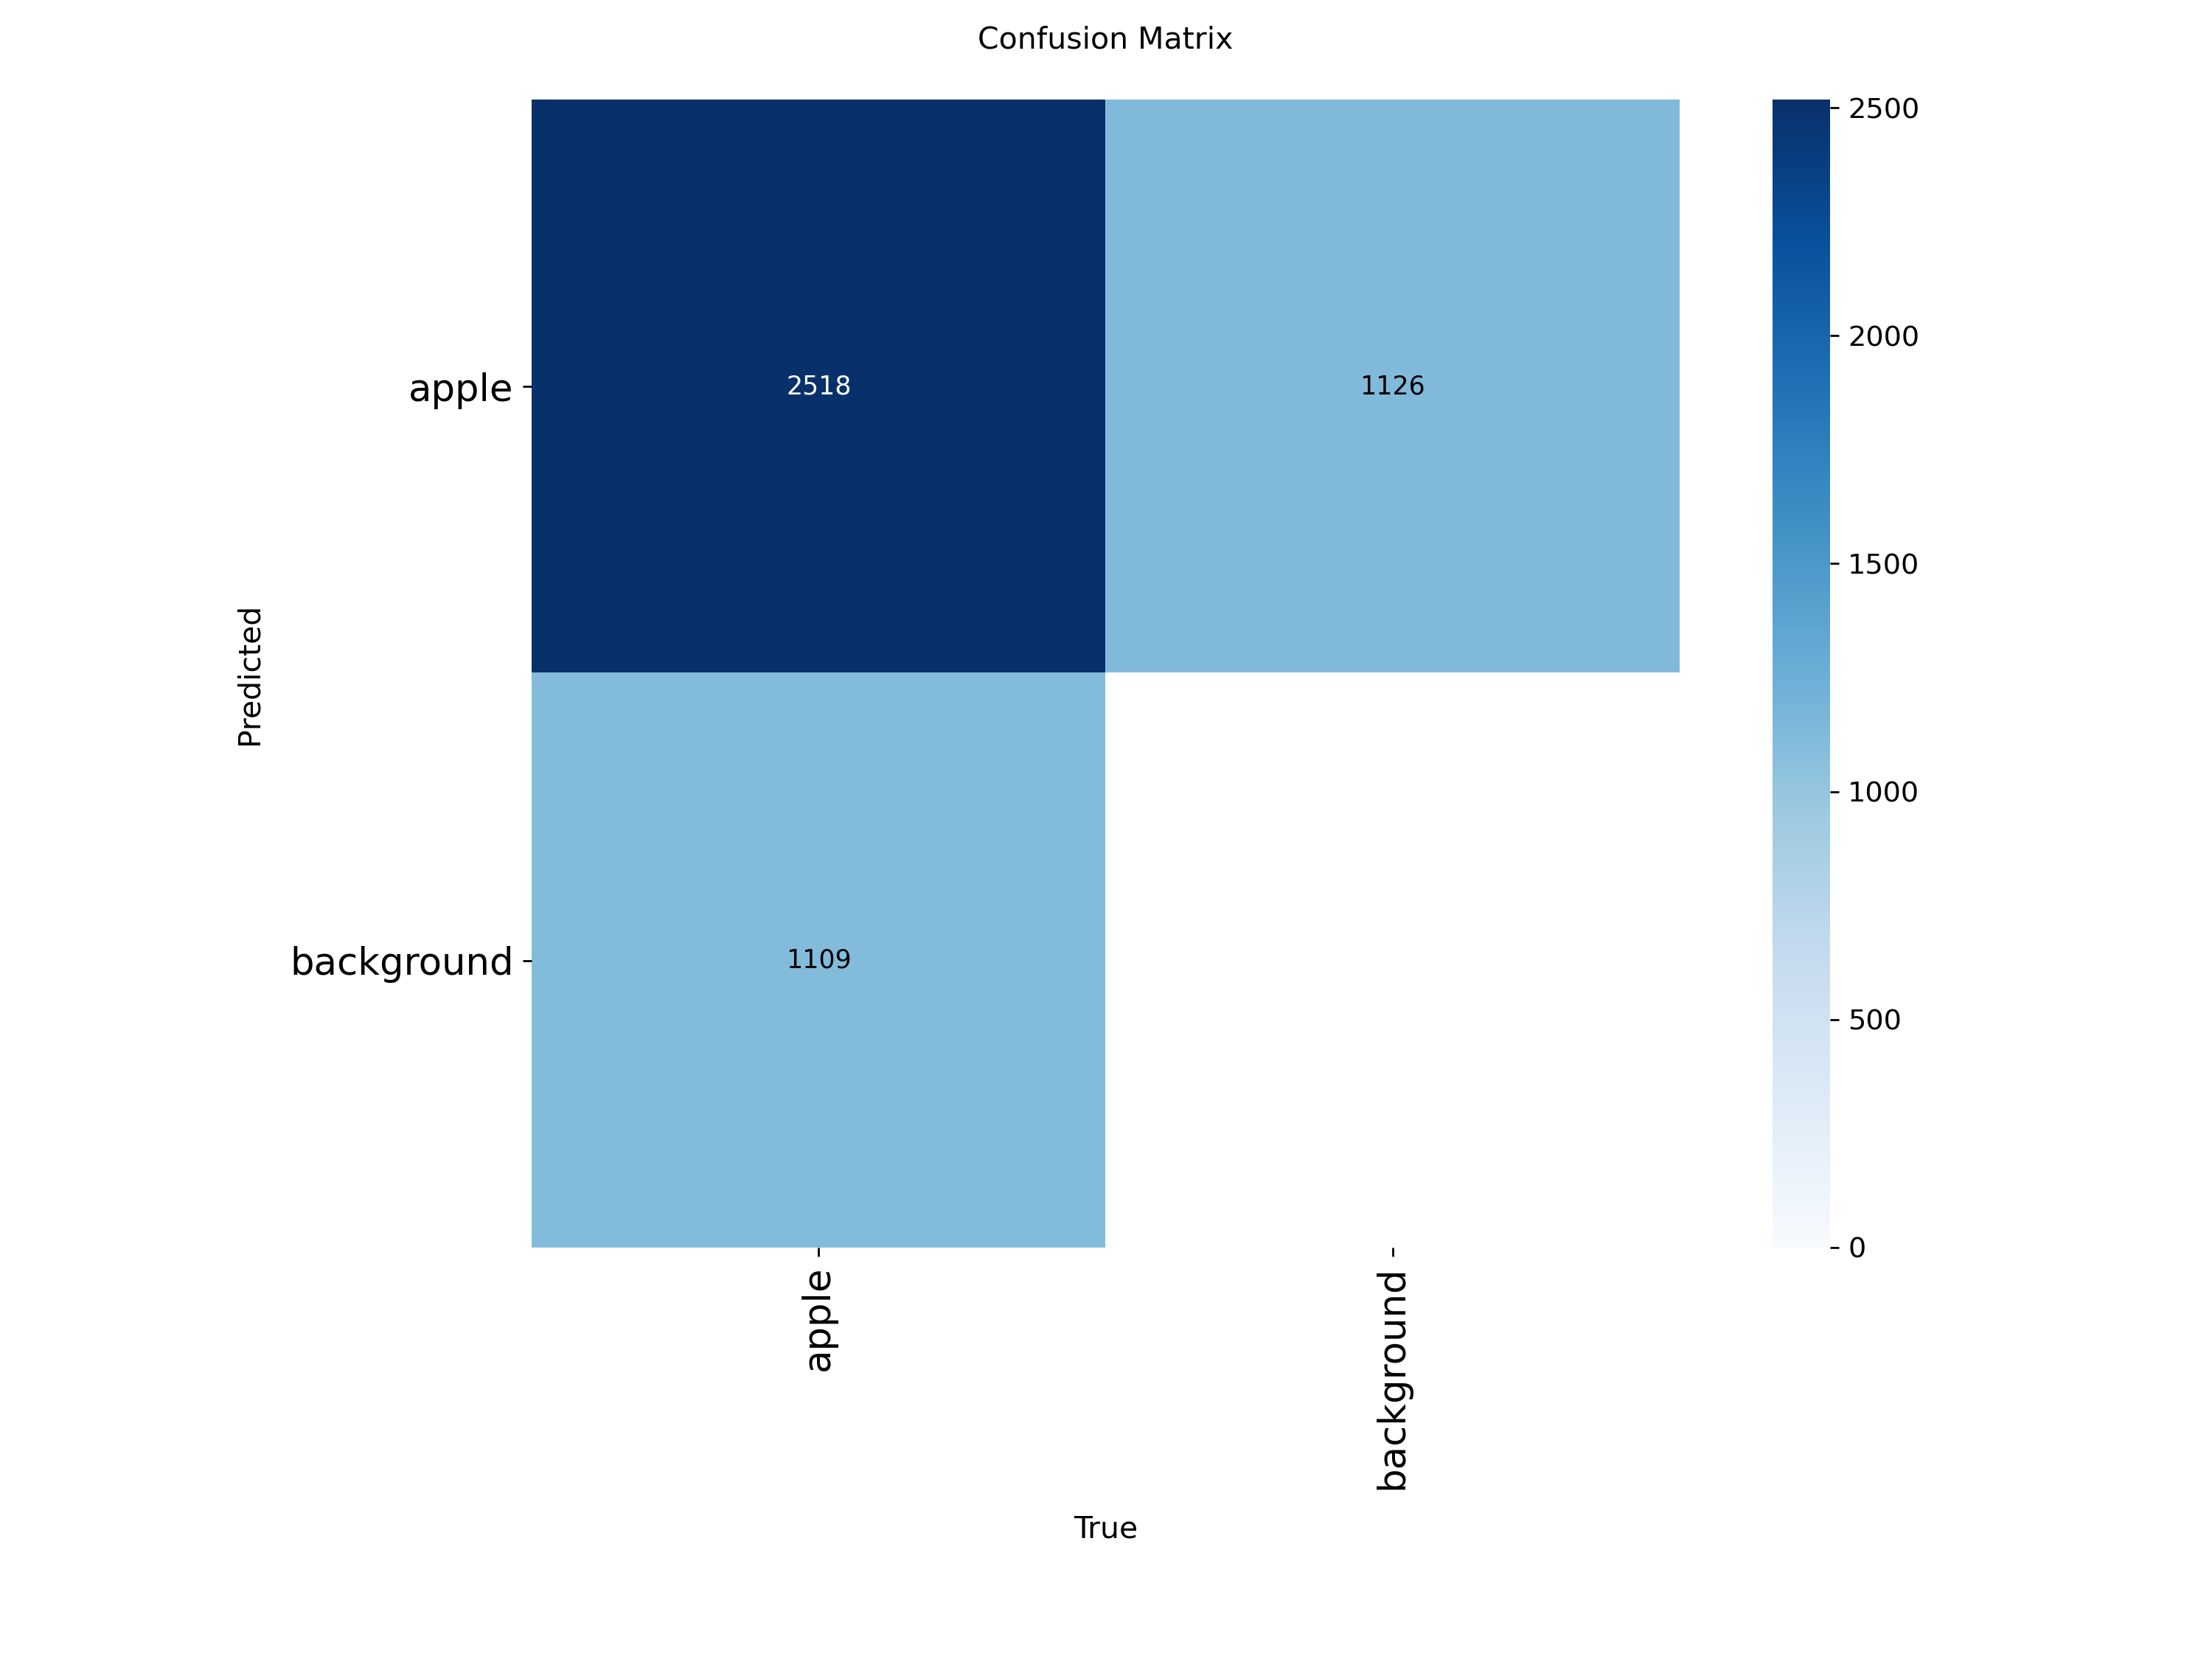


Visualizing predictions on sample images...


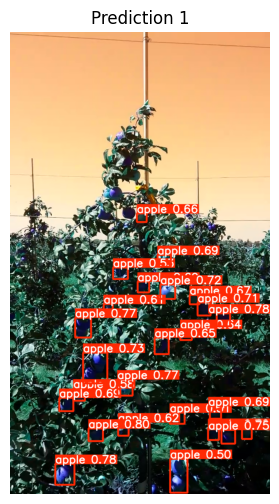

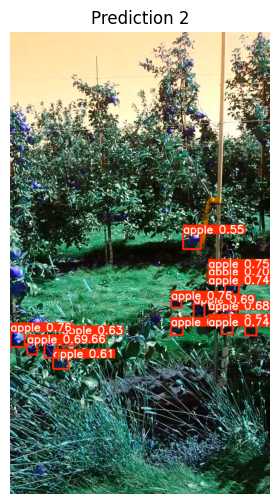

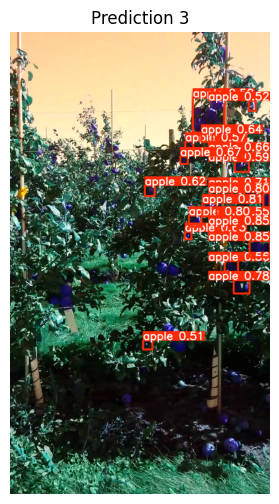


Saving model...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.30GHz)
WARNING ⚠️ half=True only compatible with GPU export, i.e. use device=0

PyTorch: starting from 'runs/detect/experiment4/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (49.7 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.61...
ONNX: export success ✅ 19.0s, saved as 'runs/detect/experiment4/weights/best.onnx' (93.0 MB)

Export complete (23.6s)
Results saved to /content/runs/detect/experiment4/weights
Predict:         yolo predict task=detect model=runs/detect/experiment4/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/experiment4/weights/best.onnx imgsz=640 data=/content/drive/MyDrive/minneApple_dataset/minneapple.yaml  
Visualize:       https://netron.app
Model exported in ONNX format

Training and evaluation completed!
Model saved in: runs/detect/experiment
Predictions v

In [12]:

if __name__ == "__main__":
    # Configuration
    EPOCHS = 100
    print(os.getcwd())

    # Set-up dataset location
    dataset_path = Path("/content/drive/MyDrive/minneApple_dataset")
    val_images_path = os.path.join(dataset_path, "valid/images")


    # Verify dataset structure
    print("\nDataset structure:")
    print(f"Images directory: {dataset_path / 'train' / 'images'}")
    num_images = len(list((dataset_path / 'train' / 'images').glob('*.png')))
    print(f"Number of images: {num_images}")
    if num_images == 0:
        raise RuntimeError("No images found in dataset")

    # Experiment name
    train_name = "experiment"

    # Train model
    print("\nStarting training process...")
    model, results = train_yolo_model(dataset_path, epochs=EPOCHS, train_name=train_name)

    model.predict(
        source=str(dataset_path / "test/images"),
        save_txt=True,
        save_conf=True,
        conf=0.1,
        project="/content/drive/MyDrive/yolo10_output",
        name="predict_test",
        exist_ok=True
    )


    # Evaluate model
    metrics = evaluate_model(model, dataset_path)
    evaluate_model_on_counting()
    show_confusion_matrix(metrics)

    # Visualize predictions
    print("\nVisualizing predictions on sample images...")
    visualize_predictions(model, dataset_path / 'minneapple.yaml', conf_threshold=0.5)

    # Save the model
    print("\nSaving model...")
    model.export(format='onnx')
    print("Model exported in ONNX format")


    print("\nTraining and evaluation completed!")
    print(f"Model saved in: runs/detect/{train_name}")
    print("Predictions visualization saved as 'predictions.png'")


    # Delete specific variables
    del model, results, metrics  # Add any other large variables
    gc.collect()
